# **APLICACIÓN DE APRENDIZAJE AUTOMÁTICO PARA EL PRONÓSTICO DE LLAMADAS ENTRANTES DESDE CABINAS DE TELEPRESENCIA**

In [ ]:
# Importar librerias
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import opendatasets as opd
import seaborn as sns
from scipy.stats import probplot
import missingno as msno
import plotly.express as px
from scipy.stats import kurtosis, skew
from sklearn import metrics as metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, recall_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.initializers import RandomUniform
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from keras import initializers

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Descargar librería
!pip install opendatasets

# EDA

In [ ]:
# Cargar los archivos CSV
data_path = "/content/drive/MyDrive/Proyecto/Base_Historica.csv"

In [ ]:
# Importar datos
data= pd.read_csv(data_path,
                      na_values=['NA', ' ', '  ', 'NaN'],sep=",",encoding='latin1')

In [ ]:
# Mostrar datos
data.head()

In [ ]:
# Información del dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210644 entries, 0 to 210643
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Dia             210644 non-null  int64 
 1   Mes             210644 non-null  int64 
 2   Año             210644 non-null  int64 
 3   Dia de Semana   210644 non-null  object
 4   Fin de Semana   210644 non-null  int64 
 5   Semana del Año  210644 non-null  int64 
 6   Es Feriado      210644 non-null  int64 
 7   Rango Horario   210644 non-null  object
 8   Region          210644 non-null  object
 9   Canal           210644 non-null  object
 10  CAC             210644 non-null  object
 11  Tipo atencion   210644 non-null  object
 12  Llamadas        210644 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 20.9+ MB


In [ ]:
# Descriptivo de los datos
data.describe(include="all").T

In [ ]:
!pip install sweetviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 119.3 MB/s eta 0:00:00


In [ ]:
import sweetviz as sw

In [ ]:
# Porcentaje de los valores ausentes
por_valores_perdidos = data.isnull().sum()/data.shape[0]*100
por_valores_perdidos

,0
Dia,0.0
Mes,0.0
Año,0.0
Dia de Semana,0.0
Fin de Semana,0.0
Semana del Año,0.0
Es Feriado,0.0
Rango Horario,0.0
Region,0.0
Canal,0.0


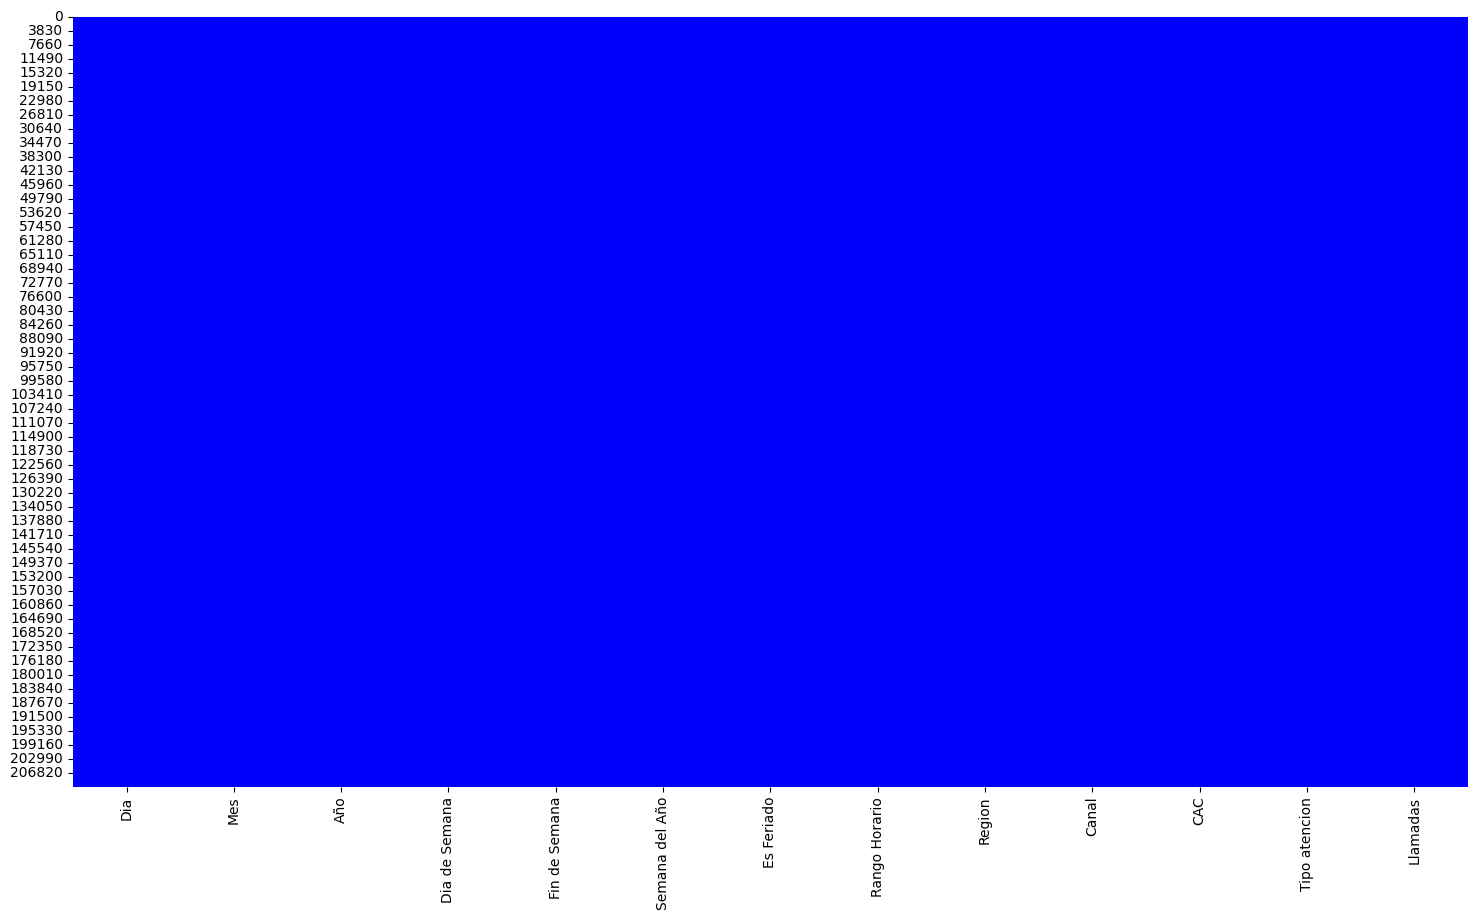

In [ ]:
# Mapa de calor de missing
plt.figure(figsize=(18,10))
sns.heatmap(data.isnull(), cbar=False, cmap="bwr")
plt.show()

In [ ]:
data2=data.copy()

In [ ]:
#Conversión de variables catégoricas

# Diccionario de mapeo
dias_map = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

# Aplicar el mapeo
data2['Dia de Semana'] = data2['Dia de Semana'].map(dias_map)


In [ ]:
#Conversión de variables categóricas

# Diccionario de mapeo
Rango_map = {
  '8 Hrs - 9 Hrs' :8,
  '9 Hrs - 10 Hrs' :9,
  '10 Hrs - 11 Hrs' :10,
  '11 Hrs - 12 Hrs' :11,
  '12 Hrs - 13 Hrs' :12,
  '13 Hrs - 14 Hrs' :13,
  '14 Hrs - 15 Hrs' :14,
  '15 Hrs - 16 Hrs' :15,
  '16 Hrs - 17 Hrs' :16,
  '17 Hrs - 18 Hrs' :17,
  '18 Hrs - 19 Hrs' :18,
  '19 Hrs - 20 Hrs' :19,
  '20 Hrs - 21 Hrs' :20,
  '21 Hrs - 22 Hrs' :21,
  '22 Hrs - 23 Hrs' :22,
}

# Aplicar el mapeo
data2['Rango Horario'] = data2['Rango Horario'].map(Rango_map)

In [ ]:
data2['Region'] = data2['Region'].astype('category').cat.codes
data2['Canal'] = data2['Canal'].astype('category').cat.codes
data2['CAC'] = data2['CAC'].astype('category').cat.codes
data2['Tipo atencion'] = data2['Tipo atencion'].astype('category').cat.codes


In [ ]:
# Variable día laboral
data2['Es_dia_laboral'] = ((data2['Fin de Semana'] == 0) & (data2['Es Feriado'] == 0)).astype(int)

In [ ]:
# Variable promedio histórico de llamadas por CAC
data2['Prom_llamadas_CAC'] = data2.groupby('CAC')['Llamadas'].transform('mean')

In [ ]:
# Variable promedio histórico de llamadas por región
data2['Prom_llamadas_region'] = data2.groupby('Region')['Llamadas'].transform('mean')

In [ ]:
# Variable frecuencia del tipo de atención por CAC
tipo_freq = data2.groupby(['CAC', 'Tipo atencion'])['Llamadas'].transform('count')
total_cac = data2.groupby(['CAC'])['Llamadas'].transform('count')
data2['Frecuencia_tipo_atencion'] = tipo_freq / total_cac

In [ ]:
#Variable estación
def obtener_estacion(mes):
    if mes in [12, 1, 2]:
        return 1#'Verano'
    elif mes in [3, 4, 5]:
        return 2#'Otoño'
    elif mes in [6, 7, 8]:
        return 3#'Invierno'
    else:
        return 4#'Primavera'

# Aplicar a la columna Mes
data2['Estacion'] = data2['Mes'].apply(obtener_estacion)

In [ ]:
# Codificación cíclica de semana del año
data2['Semana_sin'] = np.sin(2 * np.pi * data2['Semana del Año'] / 52)
data2['Semana_cos'] = np.cos(2 * np.pi * data2['Semana del Año'] / 52)

In [ ]:
# Correlaciones
data2.corr().style.background_gradient()

,Dia,Mes,Año,Dia de Semana,Fin de Semana,Semana del Año,Es Feriado,Rango Horario,Region,Canal,CAC,Tipo atencion,Llamadas,Es_dia_laboral,Prom_llamadas_CAC,Prom_llamadas_region,Frecuencia_tipo_atencion,Estacion,Semana_sin,Semana_cos
Dia,1.000000,0.017115,-0.014781,0.004756,-0.011570,0.070145,-0.002876,-0.005257,-0.000931,0.003890,0.001967,0.007702,-0.008216,0.020373,-0.002236,-0.000380,0.007620,0.010115,-0.023256,-0.014533
Mes,0.017115,1.000000,-0.741548,0.009558,0.017403,0.964333,0.061095,0.003536,-0.005075,0.003521,0.007958,0.021644,0.010018,-0.032430,0.014431,-0.006500,0.022926,0.594866,-0.786210,0.087123
Año,-0.014781,-0.741548,1.000000,-0.000295,-0.001735,-0.723882,-0.056144,-0.004281,0.002266,0.025148,0.016252,0.025261,0.023341,0.014212,-0.021269,-0.003741,0.026157,-0.586054,0.610635,0.374195
Dia de Semana,0.004756,0.009558,-0.000295,1.000000,0.729754,0.014650,0.011506,0.012908,-0.024573,-0.048962,-0.019259,0.016815,0.011557,-0.697453,0.083233,0.055592,0.012252,0.007420,-0.022373,0.021162
Fin de Semana,-0.011570,0.017403,-0.001735,0.729754,1.000000,0.012821,0.000801,0.004160,-0.021389,-0.043140,-0.014931,0.018606,0.058612,-0.952561,0.085282,0.058659,0.013853,0.013197,-0.014654,0.012933
Semana del Año,0.070145,0.964333,-0.723882,0.014650,0.012821,1.000000,0.062900,0.004258,-0.004806,0.003899,0.007733,0.021303,0.008589,-0.028041,0.012977,-0.006074,0.022607,0.619080,-0.787699,0.061632
Es Feriado,-0.002876,0.061095,-0.056144,0.011506,0.000801,0.062900,1.000000,0.017528,-0.017106,-0.027115,-0.012346,0.009182,0.027788,-0.271820,0.048412,0.030047,0.005919,0.026616,-0.056219,-0.058530
Rango Horario,-0.005257,0.003536,-0.004281,0.012908,0.004160,0.004258,0.017528,1.000000,0.005899,-0.057851,-0.009276,-0.005988,0.032802,-0.008752,0.109502,0.074318,-0.011358,0.001464,-0.004670,-0.003120
Region,-0.000931,-0.005075,0.002266,-0.024573,-0.021389,-0.004806,-0.017106,0.005899,1.000000,0.037173,-0.006290,0.005989,-0.167134,0.025474,-0.263923,-0.568641,0.013069,-0.000679,0.001128,-0.005885
Canal,0.003890,0.003521,0.025148,-0.048962,-0.043140,0.003899,-0.027115,-0.057851,0.037173,1.000000,0.726663,0.068487,-0.282078,0.048708,-0.445434,-0.278616,0.143675,-0.005027,0.007310,0.028394


In [ ]:
data2.shape

(210644, 20)

# Protocolo de experimentación

## Entrenamiento y prueba

In [ ]:
# Establecer la semilla
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# Generar data de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data2.drop('Llamadas', axis=1),
                                                    data2.Llamadas,
                                                    test_size=0.20,
                                                    random_state=SEED,
                                                    shuffle=True) # El valor es una semilla que permitira reproducir resultados

In [ ]:
X_train.shape

(117960, 19)

In [ ]:
X_train

In [ ]:
X_test.shape

(29490, 19)

In [ ]:
X_test

In [ ]:
#Normalizando
normalizador = MinMaxScaler()

X_train =normalizador.fit_transform(X_train)
X_test = normalizador.transform(X_test)

## Modelo Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import lightgbm as lgb

In [ ]:
# Hiperparámetros
n_estimators_list = [20, 30, 50, 100]
max_features_list = [0.01, 0.1, 0.3, 0.5, 1]
min_samples_split_list = [6, 7, 8, 9, 10]

# Función para calcular métricas
def calcular_metricas(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'MedAE': np.median(np.abs(y_true - y_pred)),
        'Max_Error': max_error(y_true, y_pred),
        'Explained_Var': explained_variance_score(y_true, y_pred)
    }


In [ ]:
# Ejecutar los experimentos
resultados = []

for n_estimators, max_features, min_samples_split in product(n_estimators_list, max_features_list, min_samples_split_list):
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_features=max_features,
        min_samples_split=min_samples_split,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # Predicciones
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Métricas para train y test
    metricas_train = calcular_metricas(y_train, y_train_pred)
    metricas_test = calcular_metricas(y_test, y_test_pred)

    # Unir resultados
    resultados.append({
        'n_estimators': n_estimators,
        'max_features': max_features,
        'min_samples_split': min_samples_split,
        **{f"train_{k}": v for k, v in metricas_train.items()},
        **{f"test_{k}": v for k, v in metricas_test.items()}
    })

# 🔹 Guardar en DataFrame
df_resultados = pd.DataFrame(resultados)

# 🔹 Exportar a CSV
df_resultados.to_csv("resultados_rf_completo2.csv", index=False)
print("✅ Resultados guardados en 'resultados_rf_completo.csv'.")

✅ Resultados guardados en 'resultados_rf_completo.csv'.


In [ ]:
resultados

[{'n_estimators': 20,
  'max_features': 0.01,
  'min_samples_split': 6,
  'train_R2': 0.8265354488007471,
  'train_RMSE': np.float64(1.6107260305762776),
  'train_MAE': 1.122678003175363,
  'train_MAPE': np.float64(40.454473127251376),
  'train_MedAE': np.float64(0.760357142857143),
  'train_Max_Error': np.float64(22.527738095238092),
  'train_Explained_Var': 0.8265590093800215,
  'test_R2': 0.6623725019814963,
  'test_RMSE': np.float64(2.255778715686831),
  'test_MAE': 1.5573660944875396,
  'test_MAPE': np.float64(57.09546736805445),
  'test_MedAE': np.float64(1.0524999999999998),
  'test_Max_Error': np.float64(46.90133297258297),
  'test_Explained_Var': 0.6625296669093885},
 {'n_estimators': 20,
  'max_features': 0.01,
  'min_samples_split': 7,
  'train_R2': 0.8059458735665992,
  'train_RMSE': np.float64(1.703639692320926),
  'train_MAE': 1.1848285044081504,
  'train_MAPE': np.float64(42.59507389777919),
  'train_MedAE': np.float64(0.8025252525252526),
  'train_Max_Error': np.float64

In [ ]:
print(len(resultados))

## Modelo LGBM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    explained_variance_score, max_error
)
from sklearn.model_selection import train_test_split
from itertools import product
import lightgbm as lgb

In [ ]:
# Hiperparámetros
param_grid = {
    'n_estimators': [100, 300, 500],
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [-1, 5, 10],
    'min_child_samples': [1, 20],
    'objective': ['regression'],
    'boosting_type': ['gbdt']
}

# Función de métricas
def calcular_metricas(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'MedAE': np.median(np.abs(y_true - y_pred)),
        'Max_Error': max_error(y_true, y_pred),
        'Explained_Var': explained_variance_score(y_true, y_pred)
    }

In [ ]:
# Ejecutar experimentos
resultados = []

# Crear combinaciones de hiperparámetros
param_names = list(param_grid.keys())
param_values = list(param_grid.values())
for valores in product(*param_values):
    params = dict(zip(param_names, valores))

    # Crear modelo con los parámetros actuales
    model = lgb.LGBMRegressor(
        n_estimators=params['n_estimators'],
        num_leaves=params['num_leaves'],
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        min_child_samples=params['min_child_samples'],
        objective=params['objective'],
        boosting_type=params['boosting_type'],
        n_jobs=-1,
        random_state=42
    )

    # Entrenar y predecir
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calcular métricas
    metricas_train = calcular_metricas(y_train, y_train_pred)
    metricas_test = calcular_metricas(y_test, y_test_pred)

    # Guardar resultados
    resultados.append({
        **params,
        **{f"train_{k}": v for k, v in metricas_train.items()},
        **{f"test_{k}": v for k, v in metricas_test.items()}
    })

# Crear DataFrame y exportar
df_resultados_lgbm = pd.DataFrame(resultados)
df_resultados_lgbm.to_csv("resultados_lgbm_protocolo.csv", index=False)
print("✅ Resultados guardados en 'resultados_lgbm_protocolo.csv'.")



Se han truncado las últimas 5000 líneas del flujo de salida.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [ ]:
resultados

[{'n_estimators': 100,
  'num_leaves': 31,
  'learning_rate': 0.01,
  'max_depth': -1,
  'min_child_samples': 1,
  'objective': 'regression',
  'boosting_type': 'gbdt',
  'train_R2': 0.5511228241912762,
  'train_RMSE': np.float64(2.5910755157959406),
  'train_MAE': 1.9295515084604402,
  'train_MAPE': np.float64(81.21161570999107),
  'train_MedAE': np.float64(1.5929417752382902),
  'train_Max_Error': np.float64(35.75482488663897),
  'train_Explained_Var': 0.5511228241912765,
  'test_R2': 0.5463049026150528,
  'test_RMSE': np.float64(2.614927380441897),
  'test_MAE': 1.9331333819966874,
  'test_MAPE': np.float64(81.64144089871527),
  'test_MedAE': np.float64(1.5929417752382902),
  'test_Max_Error': np.float64(48.930953526441385),
  'test_Explained_Var': 0.5463049301316227},
 {'n_estimators': 100,
  'num_leaves': 31,
  'learning_rate': 0.01,
  'max_depth': -1,
  'min_child_samples': 20,
  'objective': 'regression',
  'boosting_type': 'gbdt',
  'train_R2': 0.5511228241912762,
  'train_RMSE

In [ ]:
print(len(resultados))

108


## Modelo XGBoost

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    explained_variance_score, max_error
)
from itertools import product

In [ ]:
# Hiperparámetros del protocolo
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.001, 0.0001],
    'subsample': [0.8, 0.9, 1.0],
    'n_estimators': [1000],
    'n_jobs': [2],
    'objective': ['reg:squarederror'],
    'reg_lambda': [1, 2],
    'reg_alpha': [0, 0.5]
}

# Función de métricas
def calcular_metricas(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'MedAE': np.median(np.abs(y_true - y_pred)),
        'Max_Error': max_error(y_true, y_pred),
        'Explained_Var': explained_variance_score(y_true, y_pred)
    }

# Ejecutar combinaciones
param_names = list(param_grid.keys())
param_values = list(param_grid.values())
resultados = []

for valores in product(*param_values):
    params = dict(zip(param_names, valores))

    model = xgb.XGBRegressor(
        **params,
        random_state=42,
        verbosity=0
    )

    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    metricas_train = calcular_metricas(y_train, y_train_pred)
    metricas_test = calcular_metricas(y_test, y_test_pred)

    resultados.append({
        **params,
        **{f"train_{k}": v for k, v in metricas_train.items()},
        **{f"test_{k}": v for k, v in metricas_test.items()}
    })

# Guardar resultados
df_resultados_xgb = pd.DataFrame(resultados)
df_resultados_xgb.to_csv("resultados_xgboost_protocolo.csv", index=False)
print("✅ Resultados guardados en 'resultados_xgboost_protocolo.csv'.")


✅ Resultados guardados en 'resultados_xgboost_protocolo.csv'.


In [ ]:
resultados

[{'max_depth': 3,
  'learning_rate': 0.01,
  'subsample': 0.8,
  'n_estimators': 1000,
  'n_jobs': 2,
  'objective': 'reg:squarederror',
  'reg_lambda': 1,
  'reg_alpha': 0,
  'train_R2': 0.6472227573394775,
  'train_RMSE': np.float64(2.2973579366137353),
  'train_MAE': 1.61005437374115,
  'train_MAPE': np.float64(58.87848074096363),
  'train_MedAE': np.float64(1.1039783358573914),
  'train_Max_Error': np.float64(33.332716941833496),
  'train_Explained_Var': 0.6472227900628083,
  'test_R2': 0.6367205381393433,
  'test_RMSE': np.float64(2.3306816451415573),
  'test_MAE': 1.632131576538086,
  'test_MAPE': np.float64(59.535019138055),
  'test_MedAE': np.float64(1.102295994758606),
  'test_Max_Error': np.float64(28.598709106445312),
  'test_Explained_Var': 0.6367253817868131},
 {'max_depth': 3,
  'learning_rate': 0.01,
  'subsample': 0.8,
  'n_estimators': 1000,
  'n_jobs': 2,
  'objective': 'reg:squarederror',
  'reg_lambda': 1,
  'reg_alpha': 0.5,
  'train_R2': 0.6470571756362915,
  'tra

In [ ]:
print(len(resultados))

144


## Modelo Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
# Definir el modelo base
gbr = GradientBoostingRegressor()

# Hiperparámetros del protocolo
param_grid = {
    'n_estimators': [100, 300, 500],             # Número de árboles
    'learning_rate': [0.001, 0.01, 0.05],        # Tasa de aprendizaje
    'max_depth': [3, 5, 7, 9],                   # Profundidad del árbol
    'min_samples_split': [10],                   # Mínimo de muestras para dividir
    'min_samples_leaf': [5],                     # Mínimo de muestras en hoja
    'subsample': [0.8, 1],                       # Submuestreo
    'max_features': [0.8, 1]                     # Máximo de características usadas
}

# Función de métricas
def calcular_metricas(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'MedAE': np.median(np.abs(y_true - y_pred)),
        'Max_Error': max_error(y_true, y_pred),
        'Explained_Var': explained_variance_score(y_true, y_pred)
    }

# 🔹 Ejecutar combinaciones
param_names = list(param_grid.keys())
param_values = list(param_grid.values())
resultados = []

for valores in product(*param_values):
    params = dict(zip(param_names, valores))

    model = GradientBoostingRegressor(
        **params,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    metricas_train = calcular_metricas(y_train, y_train_pred)
    metricas_test = calcular_metricas(y_test, y_test_pred)

    resultados.append({
        **params,
        **{f"train_{k}": v for k, v in metricas_train.items()},
        **{f"test_{k}": v for k, v in metricas_test.items()}
    })

# 🔹 Guardar resultados
df_resultados_gbr = pd.DataFrame(resultados)
df_resultados_gbr.to_csv("resultados_gradient_boosting.csv", index=False)
print("✅ Resultados guardados en 'resultados_gradient_boosting.csv'.")


✅ Resultados guardados en 'resultados_gradient_boosting.csv'.


In [ ]:
df_resultados_gbr

,n_estimators,learning_rate,max_depth,min_samples_split,min_samples_leaf,subsample,max_features,train_R2,train_RMSE,train_MAE,...,train_MedAE,train_Max_Error,train_Explained_Var,test_R2,test_RMSE,test_MAE,test_MAPE,test_MedAE,test_Max_Error,test_Explained_Var
0,100,0.001,3,10,5,0.8,0.8,0.093748,3.682161,2.820058,...,2.375245,41.957990,0.093748,0.092687,3.683334,2.830629,124.511719,2.375245,39.957990,0.092720
1,100,0.001,3,10,5,0.8,1.0,0.026069,3.817180,2.934736,...,2.554005,42.543891,0.026069,0.026087,3.816125,2.943763,129.572101,2.554472,40.525671,0.026123
2,100,0.001,3,10,5,1.0,0.8,0.094740,3.680146,2.820107,...,2.390048,41.915199,0.094740,0.093675,3.681327,2.830668,124.523036,2.390048,39.915199,0.093708
3,100,0.001,3,10,5,1.0,1.0,0.023521,3.822168,2.939417,...,2.563333,42.551578,0.023521,0.023567,3.821059,2.948424,129.719853,2.563335,40.540198,0.023603
4,100,0.001,5,10,5,0.8,0.8,0.107378,3.654367,2.804677,...,2.442600,41.602385,0.107378,0.105715,3.656795,2.815534,123.860597,2.442600,39.602385,0.105748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,500,0.050,7,10,5,1.0,1.0,0.697950,2.125779,1.487669,...,1.030949,31.887433,0.697950,0.673181,2.210632,1.547257,56.271103,1.073438,30.209504,0.673185
140,500,0.050,9,10,5,0.8,0.8,0.815887,1.659665,1.179088,...,0.819403,21.435335,0.815887,0.710979,2.078868,1.446299,50.904941,0.978397,28.457839,0.710985
141,500,0.050,9,10,5,0.8,1.0,0.744036,1.956898,1.366149,...,0.938828,30.283562,0.744036,0.694270,2.138116,1.491958,53.458062,1.022792,31.128546,0.694279
142,500,0.050,9,10,5,1.0,0.8,0.801924,1.721450,1.209668,...,0.829683,23.893165,0.801924,0.712117,2.074774,1.440826,50.606958,0.977406,28.420516,0.712122
